In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install numba
import numba

In [3]:
import sys
sys.path.append('../')
from rgbd_dataloader import get_train_dataset, get_test_dataset, get_valid_dataset, get_novel_dataset

In [4]:
@numba.njit
def joint_bilateral_filter(in_img0, in_img1, out_img, x, y, padding, sigma_d, sigma_r):
    for i in range(padding, x-padding):
        for j in range(padding, y-padding):
            nom = 0.0
            denom = 0.0
            for k in range(i-padding, i+padding):
                for l in range(j-padding, j+padding):
                    img0_proc = -(((i - k)**2 + (j - l)**2)/(2*sigma_d**2))
                    minus = in_img0[i][j] - in_img0[k][l]
                    img1_norm = np.linalg.norm(minus)
                    img1_proc = img1_norm/(2*sigma_r**2)
                    w_i_j_k_l = math.exp(img0_proc - img1_proc)
                    nom += w_i_j_k_l * in_img1[k][l]
                    denom += w_i_j_k_l
            out_img[i][j] = (nom / denom)
    return out_img

In [5]:
MIN_DEPTH = 450
MIN_CLIP = 450
MAX_DEPTH = 2000

In [6]:
transparent_matching_list_valid, opaque_matching_list_valid, matching_masks_valid = get_valid_dataset(min_depth=MIN_DEPTH, max_depth=MAX_DEPTH, min_clip=MIN_CLIP)

../data/dishwasher2/val/transparent/depth/*.bin
Transparent depth test size: 26
Opaque depth test size: 26


In [7]:
padding = 7
sigma_d = 16
sigma_r = 2

In [19]:
jbf_res = joint_bilateral_filter(transparent_matching_list_valid[0][1].numpy(), tf.squeeze(transparent_matching_list_valid[0][0]).numpy(), np.zeros(shape=(512, 512), dtype=float), 512, 512, padding, sigma_d, sigma_r)

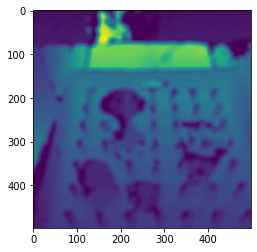

In [44]:
plt.imshow(jbf_res[padding:-padding,padding:-padding])

In [9]:
import helper_functions

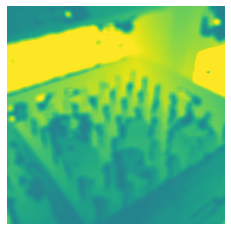

In [11]:
depth_jbfs = []
ids = [4, 8, 9, 14, 23, 24]
for i, item in enumerate(transparent_matching_list_valid):
    if i in ids:
        depth_jbf = joint_bilateral_filter(item[1].numpy(), tf.squeeze(item[0]).numpy(), np.zeros(shape=(512, 512), dtype=float), 512, 512, padding, sigma_d, sigma_r)
        plt.imshow(helper_functions.decenter_and_descale_depth_bin(depth_jbf[padding:-padding,padding:-padding], MIN_DEPTH, MAX_DEPTH), vmin=0, vmax=1000)
        plt.axis('off')
        plt.savefig(f'../data/val/jbf/{i:0>2}.png', bbox_inches='tight')

In [36]:
rmse = lambda error: np.sqrt(np.mean(np.square(error)))
mae = lambda error: np.mean(np.abs(error))
me = lambda error: np.mean(error)
rel = lambda estimated, gt: np.abs(estimated - gt) / gt
def thresh(estimated, gt, theta, mask):
    r = rel(estimated, gt)[mask]
    if len(r) == 0:
        return 0.0
    return len(r[r < theta]) / len(r)

In [47]:
def measure(min_depth=MIN_DEPTH, max_depth=MAX_DEPTH, min_depth_valid=MIN_DEPTH):
    data = []
    n = len(opaque_matching_list_valid)
    for i in range(n):
        opaque = tf.concat(opaque_matching_list_valid[i], 2)[padding:-padding,padding:-padding]
        jbf_opaque = depth_jbfs[i][padding:-padding,padding:-padding]
        depth = jbf_opaque
        depth_raw = helper_functions.decenter_and_descale_depth_bin(depth, min_depth, max_depth)
        gt = opaque[:,:,0].numpy()
        gt_raw = helper_functions.decenter_and_descale_depth_bin(gt, min_depth, max_depth)
        generated_valid = depth_raw > min_depth_valid
        gt_valid = gt_raw > min_depth_valid
        mask = matching_masks_valid[i][padding:-padding,padding:-padding]
        mask_valid = matching_masks_valid[i][padding:-padding,padding:-padding] == 1
        valid = generated_valid & gt_valid
        valid_masked = generated_valid & gt_valid & mask_valid
        
        rel_depth_gt = rel(depth_raw[gt_valid], gt_raw[gt_valid]) if np.any(gt_valid) else np.inf
        rel_depth_gt_match = rel(depth_raw[gt_valid & mask_valid], gt_raw[gt_valid & mask_valid]) if np.any(gt_valid & mask_valid) else np.inf
          
        data.append([rmse((depth_raw - gt_raw)[valid]) if np.any(valid) else np.inf,
                     rmse((depth_raw - gt_raw)[valid_masked]) if np.any(valid_masked) else np.inf,
                     mae((depth_raw - gt_raw)[valid]) if np.any(valid) > 0 else np.inf,
                     mae((depth_raw - gt_raw)[valid_masked]) if np.any(valid_masked) > 0 else np.inf,
                     np.mean(rel_depth_gt),
                     np.mean(rel_depth_gt_match),
                     thresh(depth_raw, gt_raw, 0.05, mask_valid),
                     thresh(depth_raw, gt_raw, 0.10, mask_valid),
                     thresh(depth_raw, gt_raw, 0.25, mask_valid),
                     thresh(depth_raw, gt_raw, (math.pow(1.25, 2) - 1), mask_valid),
                     thresh(depth_raw, gt_raw, (math.pow(1.25, 3) - 1), mask_valid)
                    ])

    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    df = pd.DataFrame(data, 
                      columns=["Generated vs GT RMSE", 
                               "Generated vs GT RMSE (masked)", 
                               "Generated vs GT MAE", 
                               "Generated vs GT MAE (masked)", 
                               "Relative error",
                               "Relative error (masked)",
                               "1.05",
                              "1.10",
                              "1.25",
                              "1.25 ** 2",
                              "1.25 ** 3"])
    df.loc['mean'] = df.mean()
    print(df)

In [48]:
measure()

      Generated vs GT RMSE  Generated vs GT RMSE (masked)  Generated vs GT MAE  Generated vs GT MAE (masked)  Relative error  Relative error (masked)      1.05      1.10      1.25  1.25 ** 2  1.25 ** 3
0                67.801365                      67.960351            28.411758                     41.991878        0.040833                 0.068719  0.583311  0.742236  0.902395   0.996797   1.000000
1                73.765593                      69.265650            33.972435                     52.406873        0.047028                 0.085969  0.421708  0.650935  0.957914   0.997937   1.000000
2                48.836023                      41.134501            21.652970                     28.289066        0.035163                 0.056815  0.612304  0.819978  0.987809   1.000000   1.000000
3                50.839714                      52.584485            25.040929                     37.308068        0.038190                 0.069089  0.503713  0.745866  0.980807   0.998007  

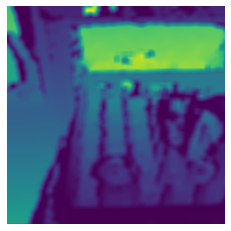

In [54]:
for i, depth_jbf in enumerate(depth_jbfs):
    plt.imshow(helper_functions.decenter_and_descale_depth_bin(depth_jbf[padding:-padding,padding:-padding]), vmin=450, vmax=1000)
    plt.axis('off')
    plt.savefig(f'../data/val/jbf/{i:0>2}.png', bbox_inches='tight')